In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install spacy transformers sentencepiece rouge

In [ ]:
import spacy
import json
import pandas as pd
import os
from rouge import Rouge
import copy

In [ ]:
#FUNC: save JSONL file
def save_jsonl(dataset, fname):
    f = open(fname, 'w', encoding='utf-8')
    for i in dataset:
        json.dump(i, f, ensure_ascii=False)
        f.write("\n")
    print('JSONL File saved..')

In [ ]:
#Func : Read JSON Line from dataset file & Return JSON Obj
def read_jsonl(file_name):
  data = []
  #Opening JSON file of Scrapped Summaries for finding links for retrieval
  with open(file_name, 'r', encoding='utf-8') as f:
    for line in f:
      data.append(json.loads(line))
    print ('No of Article / Summaries Pair : ', len(data))
  return data

In [ ]:
#FUNC: token length using spacy
def word_len(text):
  len_word = 0
  nlp = spacy.blank('ur')
  doc = nlp(text)
  for word in doc:
    len_word += 1
  return len_word

In [ ]:
#Func : Split Test and Train from Dataset
def train_test_split(df, frac=0.1):
    # get random sample
    test = df.sample(frac=frac, axis=0)
    # get everything but the test sample
    train = df.drop(index=test.index)
    return train, test

In [ ]:
#Func : Read Stop Words
def remove_stopwords(text, file_name='/content/drive/MyDrive/Urdu/BBC New/StopWords.txt'):
  words = []
  with open(file_name, 'r', encoding='utf-8') as f:
    for line in f:
      words.append(line.rstip())
  for w in words:
    text.replace(w, '')
  return text

In [ ]:
ds = read_jsonl('/content/drive/MyDrive/Urdu/BBC New/Articles.jsonl')

No of Article / Summaries Pair :  4959


In [ ]:
# Load Dataset in pandas df
df = pd.DataFrame(read_jsonl('/content/drive/MyDrive/Urdu/BBC New/Articles.jsonl'))
# Drop unneccessary columns BBCUr
df = df.drop([ 'firstPublished','title'], axis=1)
df

No of Article / Summaries Pair :  4959


url  \
0     https://www.bbc.com/urdu/articles/cv20nxzl544o   
1     https://www.bbc.com/urdu/articles/c109pqg9v1vo   
2     https://www.bbc.com/urdu/articles/cj78ev79mdmo   
3     https://www.bbc.com/urdu/articles/c3gl4pp0gzgo   
4     https://www.bbc.com/urdu/articles/c2q3k4nq39no   
...                                              ...   
4954  https://www.bbc.com/urdu/articles/cz4dp89r8p8o   
4955  https://www.bbc.com/urdu/articles/cn0995kvnzgo   
4956  https://www.bbc.com/urdu/articles/cy0ddzg77zko   
4957  https://www.bbc.com/urdu/articles/czd8jkzn0nno   
4958  https://www.bbc.com/urdu/articles/crgye1440r0o   

                                                summary            id  \
0     پاکستان کے زیرانتظام کشمیر میں بجلی کی قیمتوں ...  cv20nxzl544o   
1     پاکستان میں معیشت اور ٹیکس کے ماہرین کے مطابق ...  c109pqg9v1vo   
2     تحقیقات سے پتا چلا ہے کہ ماسکو کا ساتھ نہ دینے...  cj78ev79mdmo   
3     رقبے کے لحاظ سے دنیا کے دوسرے سب سے بڑے ملک کے...  c3gl4pp0gzgo   
4     انڈیا کے وزیر اعظم نریندر مودی کا کہنا ہے کہ د...  c2q3k4nq39no   
...                                                 ...           ...   
4954  انڈیا کی شمالی ریاست اتراکھنڈ کے شہر ہلدوانی م...  cz4dp89r8p8o   
4955  کانگریس پارٹی نے گزشتہ سال اپنی حکومت بناتے ہو...  cn0995kvnzgo   
4956  انتہا پسند ہندو تنظیموں کے ارکان نے اس فلم کے ...  cy0ddzg77zko   
4957  نوکری ٹھکرا کر یا نوکری چھوڑ کر اپنا کاروبار ش...  czd8jkzn0nno   
4958  یو پی بورڈ میں ٹاپ کرنے والی طالبہ پراچی کہتی ...  crgye1440r0o   

                                                article  
0     [’میرا دو ماہ کا بجلی کا بل 80 ہزار روپے آیا ہ...  
1     [بین الاقوامی مالیاتی فنڈ (آئی ایم ایف)  کی م...  
2     [گذشتہ سال فروری میں جب یوکرین میں جنگ شروع ہو...  
3     [عموماً یورپی اور سکینڈینیوین ممالک کا شمار دن...  
4     [انڈیا کے وزیر اعظم نریندر مودی نے ایک حالیہ ر...  
...                                                 ...  
4954  [انڈیا کی شمالی ریاست اتراکھنڈ کے شہر ہلدوانی ...  
4955  [انڈیا کی جنوبی ریاست کرناٹک میں پیش آنے والے ...  
4956  [ایک انڈین فلم، جسے ’ہندوؤں کے مذہبی جذبات مجر...  
4957  [نوکری کو ٹھکرا کر یا نوکری کو چھوڑ کر اپنا کا...  
4958  [یو پی بورڈ کے نتائج کا پانچواں دن تھا۔ صبح سا...  

[4959 rows x 4 columns]

In [ ]:
t_len_summary = []
t_len_article = []
ratio = []

#cats = df["category"].value_counts()

count = 0
for i in ds:
  para_count = 0
  article_len = []
  for j in i['article']:
    tmp = {}
    tmp['para'] = para_count
    tmp['len'] = word_len(j)
    article_len.append(tmp)
    para_count += 1


    # Display message after every 100 articles
  #if count % 100 == 0 and count > 0:
    print(f"Total articles iterated: {count}")
    #break

  count += 1
  summary_len = word_len(i['summary'])
  t_len_article.append(article_len)
  t_len_summary.append(summary_len)
  length = sum(tmp['len'] for tmp in article_len)
  if length > 0:
    ratio.append(summary_len / length * 100)
  else:
    ratio.append(0)

Streaming output truncated to the last 5000 lines.
Total articles iterated: 4827
Total articles iterated: 4827
Total articles iterated: 4827
Total articles iterated: 4827
Total articles iterated: 4827
Total articles iterated: 4827
Total articles iterated: 4827
Total articles iterated: 4827
Total articles iterated: 4827
Total articles iterated: 4827
Total articles iterated: 4827
Total articles iterated: 4827
Total articles iterated: 4827
Total articles iterated: 4827
Total articles iterated: 4827
Total articles iterated: 4827
Total articles iterated: 4827
Total articles iterated: 4827
Total articles iterated: 4827
Total articles iterated: 4827
Total articles iterated: 4827
Total articles iterated: 4827
Total articles iterated: 4827
Total articles iterated: 4827
Total articles iterated: 4827
Total articles iterated: 4827
Total articles iterated: 4827
Total articles iterated: 4827
Total articles iterated: 4827
Total articles iterated: 4827
Total articles iterated: 4827
Total articles iter

In [ ]:
with open('/content/drive/MyDrive/Urdu/BBC New/Length-Article-Initial.jsonl', 'w', encoding='utf-8') as f:
  for i in t_len_article:
    for j in i:
      json.dump(j, f, ensure_ascii=False)
      f.write("\n")
    f.write("||")
    f.write("\n")

with open('/content/drive/MyDrive/Urdu/BBC New/Length-Summary-Intial.txt', 'w') as f:
  for i in t_len_summary:
    f.write(str(i))
    f.write("\n")
with open('/content/drive/MyDrive/Urdu/BBC New/Ratios-Intial.txt', 'w') as f:
  for i in ratio:
    f.write(str(i))
    f.write("\n")

In [ ]:
t_len_summary = []
t_len_article = []
ratio = []

with open('/content/drive/MyDrive/Urdu/BBC New/Length-Article-Initial.jsonl', 'r', encoding='utf-8') as f:
  tmp = []
  for line in f:
    if line.rstrip() == '||':
      t_len_article.append(tmp)
      tmp = []
      continue
    tmp.append(json.loads(line))
  print ('No of Article / Summaries Pair : ', len(t_len_article))

with open('/content/drive/MyDrive/Urdu/BBC New/Length-Summary-Intial.txt', 'r') as f:
  for line in f:
    t_len_summary.append(int(line.rstrip()))
with open('/content/drive/MyDrive/Urdu/BBC New/Ratios-Intial.txt', 'r') as f:
  for line in f:
    ratio.append(float(line.rstrip()))

No of Article / Summaries Pair :  4959


In [ ]:
print('Max Tokens in Summary(s) :', max(t_len_summary))
print('Min Tokens in Summary(s) :', min(t_len_summary))
print('Avg Tokens in Summary(s) :', sum(t_len_summary)/len(t_len_summary))
print('Max Compression Ratio :', max(ratio))
print('Min Compression Ratio :', min(ratio))
print('Avg Compression Ratio :', sum(ratio)/len(ratio))
article_len = []
for i in t_len_article:
  article_len.append(sum(tmp['len'] for tmp in i))
print('Max Tokens in Article(s) :', max(article_len))
print('Min Tokens in Article(s) :', min(article_len))
print('Avg Tokens in Article(s) :', sum(article_len)/len(article_len))

Max Tokens in Summary(s) : 105
Min Tokens in Summary(s) : 0
Avg Tokens in Summary(s) : 46.76830006049607
Max Compression Ratio : 100.0
Min Compression Ratio : 0.0
Avg Compression Ratio : 4.188447478114642
Max Tokens in Article(s) : 9388
Min Tokens in Article(s) : 13
Avg Tokens in Article(s) : 1424.6144383948376


In [ ]:
pd_article=pd.DataFrame({'length': article_len})
pd_article.describe()

length
count  4959.000000
mean   1424.614438
std     719.789760
min      13.000000
25%     966.000000
50%    1324.000000
75%    1718.000000
max    9388.000000

In [ ]:
pd_summary=pd.DataFrame({'length': t_len_summary})
pd_summary.describe()

length
count  4959.000000
mean     46.768300
std      13.783806
min       0.000000
25%      38.000000
50%      45.000000
75%      56.000000
max     105.000000

In [ ]:
pd_ratio=pd.DataFrame({'length': ratio})
pd_ratio.describe()

length
count  4959.000000
mean      4.188447
std       4.940009
min       0.000000
25%       2.566261
50%       3.486239
75%       4.750566
max     100.000000

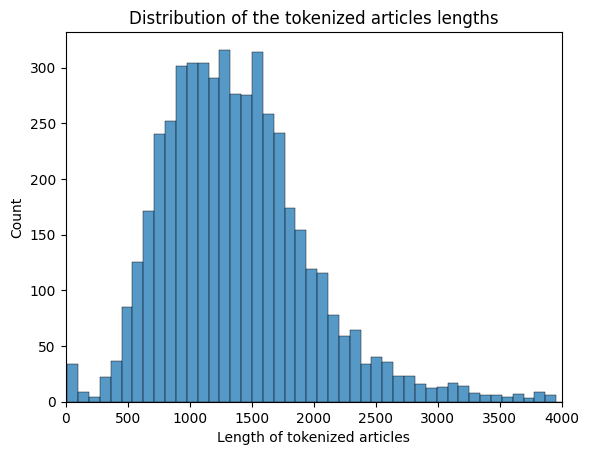

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

tokenized_articles_lengths = article_len
ax=sns.histplot(tokenized_articles_lengths)
ax.set(xlabel='Length of tokenized articles', ylabel='Count', xlim=(0, 4000), title='Distribution of the tokenized articles lengths')
plt.show()

In [ ]:
from scipy.stats import percentileofscore
print(f'Percentile of length=512: {int(percentileofscore(tokenized_articles_lengths,513))}%')

Percentile of length=512: 3%


In [ ]:
#FUNC: score paras from articles based on rouge
def score_paras(paras, summary, articleNo):
  result = []
  count = 0
  for p in paras:
    tmp = {}
    tmp['index'] = count
    tmp['para'] = p
    rouge = Rouge()
    if t_len_article[articleNo][count]['len'] > 3:
      scores = rouge.get_scores(p, summary, ignore_empty=True)
      tmp['score'] = scores[0]['rouge-1']['r']
    else:
      tmp['score'] = 0
    count += 1
    result.append(tmp)
  return result

#FUNC: trunc length of articles to 512 tokens for Bert Tokenizer
def trunc_article(paras, summary, articleNo):
  # strip blank spaces
  for p in paras:
    p = p.lstrip().rstrip()

  if len(' '.join(paras)) != 0 and len(summary) != 0:
    if article_len[articleNo] <= 512:
      #print('Length less than 512..')
      return paras, article_len[articleNo]
    else:
      result = score_paras(paras, summary, articleNo)
      result = sorted(result, key = lambda i: i['score'])

      for r in result:
        r['len'] = [item for item in t_len_article[articleNo] if item['para'] == r['index']][0]['len']

      # while length is greater than 512
      para_removed = 0

      result_paras = []
      len_article = 0

      while sum(tmp['len'] for tmp in result) > 512:
        #print('Length > 512 : ', sum(tmp['len'] for tmp in result))
        del result[0]
        para_removed += 1
        if sum(tmp['len'] for tmp in result) <= 512:
          result = sorted(result, key = lambda i: i['index'])
          tmp = {}
          for i in result:
            len_article = sum(tmp['len'] for tmp in result)
            result_paras.append(i['para'])

      return result_paras, len_article

  else:
    print("Zero Length Article/ Summary during Trunc..")
    return 0

In [ ]:
count = 0
zerocount = 0
temp_ds = copy.deepcopy(ds)

trunc_len = []
for row in temp_ds:
  trunc = trunc_article(row['article'], row['summary'], count)
  if trunc == 0:
    zerocount += 1
    count += 1
    continue
  else:
    row['article'], tmp_len = trunc
    trunc_len.append(tmp_len)
    #print('Len of Row : ',word_len(''.join(row['article'])))
  #print('After Processing : ', len(row['article']))
  if count % 100 == 0:
    print('Article Trunc : ', count)
  count += 1
print('Zero Count : ', zerocount)

Article Trunc :  0
Zero Length Article/ Summary during Trunc..
Article Trunc :  100
Article Trunc :  200
Zero Length Article/ Summary during Trunc..
Article Trunc :  300
Article Trunc :  400
Article Trunc :  500
Article Trunc :  600
Article Trunc :  700
Article Trunc :  800
Article Trunc :  900
Zero Length Article/ Summary during Trunc..
Article Trunc :  1000
Zero Length Article/ Summary during Trunc..
Article Trunc :  1100
Zero Length Article/ Summary during Trunc..
Article Trunc :  1200
Zero Length Article/ Summary during Trunc..
Zero Length Article/ Summary during Trunc..
Zero Length Article/ Summary during Trunc..
Article Trunc :  1300
Article Trunc :  1400
Zero Length Article/ Summary during Trunc..
Article Trunc :  1500
Article Trunc :  1600
Zero Length Article/ Summary during Trunc..
Article Trunc :  1700
Article Trunc :  1800
Article Trunc :  1900
Article Trunc :  2000
Article Trunc :  2100
Article Trunc :  2200
Article Trunc :  2300
Zero Length Article/ Summary during Trunc..


In [ ]:
count = 0
ds_0 = []
for i in article_len:
  copy_flag = True
  if i < 50 or ratio[count] > 50 or ratio[count] == 0:
     copy_flag = False
  if copy_flag:
    ds_0.append(temp_ds[count])
  count += 1

In [ ]:
save_jsonl(ds_0, '/content/drive/MyDrive/Urdu/BBC New/BBCUr512.jsonl')

JSONL File saved..


In [ ]:
#join paras
for i in ds_0:
  i['article'] = ' '.join(i['article'])

In [ ]:
save_jsonl(ds_0, '/content/drive/MyDrive/Urdu/BBC New/BBCUr512J.jsonl')

JSONL File saved..


In [ ]:
ds_p = read_jsonl('/content/drive/MyDrive/Urdu/BBC New/BBCUr512.jsonl')
df_p = pd.DataFrame(ds_p)

No of Article / Summaries Pair :  4916


In [ ]:
t_len_summary2 = []
t_len_article2 = []
ratio2 = []
count = 0
for i in ds_p:
  para_count = 0
  article_len = []
  for j in i['article']:
    tmp = {}
    tmp['para'] = para_count
    tmp['len'] = word_len(j)
    article_len.append(tmp)
    para_count += 1
  if count % 100 == 0 and count > 0:
    print(f"Total articles iterated: {count}")
  summary_len = word_len(i['summary'])
  count +=1

  t_len_article2.append(article_len)
  t_len_summary2.append(summary_len)
  length = sum(tmp['len'] for tmp in article_len)
  if length > 0:
    ratio2.append(summary_len / length * 100)
  else:
    ratio2.append(0)

Total articles iterated: 100
Total articles iterated: 200
Total articles iterated: 300
Total articles iterated: 400
Total articles iterated: 500
Total articles iterated: 600
Total articles iterated: 700
Total articles iterated: 800
Total articles iterated: 900
Total articles iterated: 1000
Total articles iterated: 1100
Total articles iterated: 1200
Total articles iterated: 1300
Total articles iterated: 1400
Total articles iterated: 1500
Total articles iterated: 1600
Total articles iterated: 1700
Total articles iterated: 1800
Total articles iterated: 1900
Total articles iterated: 2000
Total articles iterated: 2100
Total articles iterated: 2200
Total articles iterated: 2300
Total articles iterated: 2400
Total articles iterated: 2500
Total articles iterated: 2600
Total articles iterated: 2700
Total articles iterated: 2800
Total articles iterated: 2900
Total articles iterated: 3000
Total articles iterated: 3100
Total articles iterated: 3200
Total articles iterated: 3300
Total articles iter

In [ ]:
with open('/content/drive/MyDrive/Urdu/BBC New/Length-Article-512.jsonl', 'w', encoding='utf-8') as f:
  for i in t_len_article2:
    for j in i:
      json.dump(j, f, ensure_ascii=False)
      f.write("\n")
    f.write("||")
    f.write("\n")

with open('/content/drive/MyDrive/Urdu/BBC New/Length-Summary-512.txt', 'w') as f:
  for i in t_len_summary2:
    f.write(str(i))
    f.write("\n")
with open('/content/drive/MyDrive/Urdu/BBC New/Ratios-512.txt', 'w') as f:
  for i in ratio2:
    f.write(str(i))
    f.write("\n")

In [ ]:
t_len_summary2 = []
t_len_article2 = []
ratio2 = []

with open('/content/drive/MyDrive/Urdu/BBC New/Length-Article-512.jsonl', 'r', encoding='utf-8') as f:
  tmp = []
  for line in f:
    if line.rstrip() == '||':
      t_len_article2.append(tmp)
      tmp = []
      continue
    tmp.append(json.loads(line))
  print ('No of Article / Summaries Pair : ', len(t_len_article2))

with open('/content/drive/MyDrive/Urdu/BBC New/Length-Summary-512.txt', 'r') as f:
  for line in f:
    t_len_summary2.append(int(line.rstrip()))
with open('/content/drive/MyDrive/Urdu/BBC New/Ratios-512.txt', 'r') as f:
  for line in f:
    ratio2.append(float(line.rstrip()))

No of Article / Summaries Pair :  4916


In [ ]:
print('Max Tokens in Summary(s) :', max(t_len_summary2))
print('Min Tokens in Summary(s) :', min(t_len_summary2))
print('Avg Tokens in Summary(s) :', sum(t_len_summary2)/len(t_len_summary2))
print('Max Compression Ratio :', max(ratio2))
print('Min Compression Ratio :', min(ratio2))
print('Avg Compression Ratio :', sum(ratio2)/len(ratio2))
article_len = []
for i in t_len_article2:
  article_len.append(sum(tmp['len'] for tmp in i))
print('Max Tokens in Article(s) :', max(article_len))
print('Min Tokens in Article(s) :', min(article_len))
print('Avg Tokens in Article(s) :', sum(article_len)/len(article_len))

Max Tokens in Summary(s) : 105
Min Tokens in Summary(s) : 12
Avg Tokens in Summary(s) : 47.035394629780306
Max Compression Ratio : 39.23076923076923
Min Compression Ratio : 2.5210084033613445
Avg Compression Ratio : 9.821779378846337
Max Tokens in Article(s) : 512
Min Tokens in Article(s) : 71
Avg Tokens in Article(s) : 482.576688364524


In [ ]:
pd_article=pd.DataFrame({'length': article_len})
pd_article.describe()

length
count  4916.000000
mean    482.576688
std      31.201932
min      71.000000
25%     473.000000
50%     487.000000
75%     500.000000
max     512.000000

In [ ]:
pd_summary=pd.DataFrame({'length': t_len_summary2})
pd_summary.describe()

length
count  4916.000000
mean     47.035395
std      13.399107
min      12.000000
25%      38.000000
50%      45.000000
75%      56.000000
max     105.000000

In [ ]:
pd_ratio=pd.DataFrame({'length': ratio2})
pd_ratio.describe()

length
count  4916.000000
mean      9.821779
std       3.070791
min       2.521008
25%       7.773109
50%       9.421842
75%      11.548240
max      39.230769

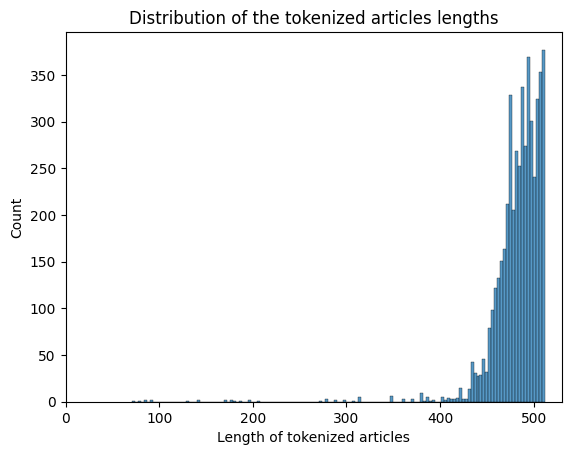

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

tokenized_articles_lengths = article_len
ax=sns.histplot(tokenized_articles_lengths)
ax.set(xlabel='Length of tokenized articles', ylabel='Count', xlim=(0, 530), title='Distribution of the tokenized articles lengths')
plt.show()

In [ ]:
from scipy.stats import percentileofscore
print(f'Percentile of length=512: {int(percentileofscore(tokenized_articles_lengths,513))}th')

Percentile of length=512: 100th


In [ ]:
df_p

url  \
0     https://www.bbc.com/urdu/articles/cv20nxzl544o   
1     https://www.bbc.com/urdu/articles/c109pqg9v1vo   
2     https://www.bbc.com/urdu/articles/cj78ev79mdmo   
3     https://www.bbc.com/urdu/articles/c3gl4pp0gzgo   
4     https://www.bbc.com/urdu/articles/c2q3k4nq39no   
...                                              ...   
4911  https://www.bbc.com/urdu/articles/cz4dp89r8p8o   
4912  https://www.bbc.com/urdu/articles/cn0995kvnzgo   
4913  https://www.bbc.com/urdu/articles/cy0ddzg77zko   
4914  https://www.bbc.com/urdu/articles/czd8jkzn0nno   
4915  https://www.bbc.com/urdu/articles/crgye1440r0o   

                                                summary  \
0     پاکستان کے زیرانتظام کشمیر میں بجلی کی قیمتوں ...   
1     پاکستان میں معیشت اور ٹیکس کے ماہرین کے مطابق ...   
2     تحقیقات سے پتا چلا ہے کہ ماسکو کا ساتھ نہ دینے...   
3     رقبے کے لحاظ سے دنیا کے دوسرے سب سے بڑے ملک کے...   
4     انڈیا کے وزیر اعظم نریندر مودی کا کہنا ہے کہ د...   
...                                                 ...   
4911  انڈیا کی شمالی ریاست اتراکھنڈ کے شہر ہلدوانی م...   
4912  کانگریس پارٹی نے گزشتہ سال اپنی حکومت بناتے ہو...   
4913  انتہا پسند ہندو تنظیموں کے ارکان نے اس فلم کے ...   
4914  نوکری ٹھکرا کر یا نوکری چھوڑ کر اپنا کاروبار ش...   
4915  یو پی بورڈ میں ٹاپ کرنے والی طالبہ پراچی کہتی ...   

                                                  title  \
0     پاکستان کے زیرانتظام کشمیر میں احتجاج کیوں ہو ...   
1     پاکستان میں متوسط طبقے اور غریبوں پر ٹیکسوں کا...   
2     معاشی پابندیوں پر روس کا جواب: ’دشمن‘ مغربی مم...   
3     کینیڈا کے تین شہر رہائش کے لیے دنیا کے 10 بہتر...   
4     کیا انڈیا، مشرق وسطیٰ اور یورپ کا راہداری منصو...   
...                                                 ...   
4911  انڈیا: ریاست اتراکھنڈ میں مدرسے کی عمارت کو گر...   
4912  ہندو لڑکے سے ملنے جانے والی مسلمان لڑکی پر ’تش...   
4913  ’برہمن عورت کی بریانی پکانے سے قبل نماز‘ نیٹ ف...   
4914  ’اپنا باس خود بننے کی خواہش یا آمدن کے محدود م...   
4915  ’اگر میں ٹاپ نہ کرتی تو لوگ میری شکل پر توجہ ن...   

                firstPublished            id  \
0     2023-10-06T06:51:11.061Z  cv20nxzl544o   
1     2023-10-05T03:03:41.630Z  c109pqg9v1vo   
2     2023-10-04T02:20:54.824Z  cj78ev79mdmo   
3     2023-10-03T04:25:50.938Z  c3gl4pp0gzgo   
4     2023-10-03T03:20:38.534Z  c2q3k4nq39no   
...                        ...           ...   
4911  2024-02-10T09:31:10.954Z  cz4dp89r8p8o   
4912  2024-01-13T03:45:15.429Z  cn0995kvnzgo   
4913  2024-01-12T15:13:09.862Z  cy0ddzg77zko   
4914  2024-04-27T06:02:58.918Z  czd8jkzn0nno   
4915  2024-04-27T10:33:29.384Z  crgye1440r0o   

                                                article  
0     [پاکستان کے زیر انتظام کشمیر میں احتجاج تو کئی...  
1     [اس شرط کے تحت زیادہ ٹیکس وصولی کے مختلف شعبوں...  
2     [تاہم، تحقیقات میں یہ بھی پتا چلا ہے کہ کریملن...  
3     [سمانتھا فالک، جو مونٹریال، کیلگری اور ٹورنٹو ...  
4     [انڈیا کے وزیر اعظم نریندر مودی نے ایک حالیہ ر...  
...                                                 ...  
4911  [انڈیا کی شمالی ریاست اتراکھنڈ کے شہر ہلدوانی ...  
4912  [خاتون نے بتایا کہ اس کے بعد انھیں ہوٹل سے سات...  
4913  [ایک انڈین فلم، جسے ’ہندوؤں کے مذہبی جذبات مجر...  
4914  [نوکری کو ٹھکرا کر یا نوکری کو چھوڑ کر اپنا کا...  
4915  [پراچی کہتی ہیں کہ ’اس ٹرولنگ اور ہجوم کو دیکھ...  

[4916 rows x 6 columns]

In [ ]:
# Drop unneccessary columns BBCUr
df_p = df_p.drop(['id'], axis=1)

In [ ]:
df_p

url  \
0     https://www.bbc.com/urdu/articles/cv20nxzl544o   
1     https://www.bbc.com/urdu/articles/c109pqg9v1vo   
2     https://www.bbc.com/urdu/articles/cj78ev79mdmo   
3     https://www.bbc.com/urdu/articles/c3gl4pp0gzgo   
4     https://www.bbc.com/urdu/articles/c2q3k4nq39no   
...                                              ...   
4911  https://www.bbc.com/urdu/articles/cz4dp89r8p8o   
4912  https://www.bbc.com/urdu/articles/cn0995kvnzgo   
4913  https://www.bbc.com/urdu/articles/cy0ddzg77zko   
4914  https://www.bbc.com/urdu/articles/czd8jkzn0nno   
4915  https://www.bbc.com/urdu/articles/crgye1440r0o   

                                                summary  \
0     پاکستان کے زیرانتظام کشمیر میں بجلی کی قیمتوں ...   
1     پاکستان میں معیشت اور ٹیکس کے ماہرین کے مطابق ...   
2     تحقیقات سے پتا چلا ہے کہ ماسکو کا ساتھ نہ دینے...   
3     رقبے کے لحاظ سے دنیا کے دوسرے سب سے بڑے ملک کے...   
4     انڈیا کے وزیر اعظم نریندر مودی کا کہنا ہے کہ د...   
...                                                 ...   
4911  انڈیا کی شمالی ریاست اتراکھنڈ کے شہر ہلدوانی م...   
4912  کانگریس پارٹی نے گزشتہ سال اپنی حکومت بناتے ہو...   
4913  انتہا پسند ہندو تنظیموں کے ارکان نے اس فلم کے ...   
4914  نوکری ٹھکرا کر یا نوکری چھوڑ کر اپنا کاروبار ش...   
4915  یو پی بورڈ میں ٹاپ کرنے والی طالبہ پراچی کہتی ...   

                                                  title  \
0     پاکستان کے زیرانتظام کشمیر میں احتجاج کیوں ہو ...   
1     پاکستان میں متوسط طبقے اور غریبوں پر ٹیکسوں کا...   
2     معاشی پابندیوں پر روس کا جواب: ’دشمن‘ مغربی مم...   
3     کینیڈا کے تین شہر رہائش کے لیے دنیا کے 10 بہتر...   
4     کیا انڈیا، مشرق وسطیٰ اور یورپ کا راہداری منصو...   
...                                                 ...   
4911  انڈیا: ریاست اتراکھنڈ میں مدرسے کی عمارت کو گر...   
4912  ہندو لڑکے سے ملنے جانے والی مسلمان لڑکی پر ’تش...   
4913  ’برہمن عورت کی بریانی پکانے سے قبل نماز‘ نیٹ ف...   
4914  ’اپنا باس خود بننے کی خواہش یا آمدن کے محدود م...   
4915  ’اگر میں ٹاپ نہ کرتی تو لوگ میری شکل پر توجہ ن...   

                firstPublished  \
0     2023-10-06T06:51:11.061Z   
1     2023-10-05T03:03:41.630Z   
2     2023-10-04T02:20:54.824Z   
3     2023-10-03T04:25:50.938Z   
4     2023-10-03T03:20:38.534Z   
...                        ...   
4911  2024-02-10T09:31:10.954Z   
4912  2024-01-13T03:45:15.429Z   
4913  2024-01-12T15:13:09.862Z   
4914  2024-04-27T06:02:58.918Z   
4915  2024-04-27T10:33:29.384Z   

                                                article  
0     [پاکستان کے زیر انتظام کشمیر میں احتجاج تو کئی...  
1     [اس شرط کے تحت زیادہ ٹیکس وصولی کے مختلف شعبوں...  
2     [تاہم، تحقیقات میں یہ بھی پتا چلا ہے کہ کریملن...  
3     [سمانتھا فالک، جو مونٹریال، کیلگری اور ٹورنٹو ...  
4     [انڈیا کے وزیر اعظم نریندر مودی نے ایک حالیہ ر...  
...                                                 ...  
4911  [انڈیا کی شمالی ریاست اتراکھنڈ کے شہر ہلدوانی ...  
4912  [خاتون نے بتایا کہ اس کے بعد انھیں ہوٹل سے سات...  
4913  [ایک انڈین فلم، جسے ’ہندوؤں کے مذہبی جذبات مجر...  
4914  [نوکری کو ٹھکرا کر یا نوکری کو چھوڑ کر اپنا کا...  
4915  [پراچی کہتی ہیں کہ ’اس ٹرولنگ اور ہجوم کو دیکھ...  

[4916 rows x 5 columns]